In [ ]:
!pip install transformers
!pip install tweepy
!pip install tqdm

!pip install wordcloud
!pip install TurkishStemmer
!pip install sklearn
!pip install nltk
!pip install pycountry

In [3]:
import tweepy

# Data Manipulation
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

# Bert Model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Metin Ön İşleme
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings(action = 'ignore')

import requests

In [4]:
consumer_key = 'M4gvZwp9UWrYUwiHoMOUlj4Ao'
consumer_secret = 'i3yFIonfKOlfUaFelAoroLCazBoeSMZqK0A8gwAmuf7Pttl8r1' 
access_token = '2825908409-8ka7j54bh3rSjRPfv2n3UAglbFbbbvFk2GuIb99'
access_token_secret ='Tmzo3DWql3dPz7aKOpvqc7LzLUabA3Dbrz7geOwpkkBSS'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [7]:
tweets_list = []
text_query = 'disney'
count = 100

for tweet in api.search(q=text_query, count=count, lang='tr-tr'):
    tweets_list.append((tweet.created_at,tweet.id,tweet.text))

In [8]:
tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
tweets.head()

,Tarih,Tweet_id,Text
0,2022-06-16 16:21:27,1537470417824370690,Disney+ o kadar iyi kiiii bütün paralı dizi pl...
1,2022-06-16 16:21:13,1537470359649275904,RT @yusuferenyasasn: İlacımı almam için çabala...
2,2022-06-16 16:21:10,1537470350040113153,hala disney plus muhabbeti yapanların zeka sev...
3,2022-06-16 16:21:07,1537470335393619969,@Kbraayyy4 @Paul41151121 @UgUrUcUcU_ @qtpiequi...
4,2022-06-16 16:20:53,1537470275096297472,@onondisneyplus Disney prenseslerinin arasında...


In [9]:
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

Downloading:   0%|          | 0.00/596 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
sentiment_analysis_pipeline("Ne kadar kaliteli bir film sitesi")


[{'label': 'positive', 'score': 0.99562007188797}]

In [11]:
sentiment_result=[]
for text in tqdm(tweets.Text):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


In [12]:
sentiment_result = pd.DataFrame(sentiment_result)
sentiment_result.head()

,label,score
0,positive,0.974509
1,negative,0.730201
2,negative,0.524493
3,negative,0.566070
4,negative,0.994164


In [13]:
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([tweets, sentiment_result],axis=1)
tweets.label = tweets.label.map({'positive':1,'negative':0})
tweets.head()

,Tarih,Tweet_id,Text,label,score
0,2022-06-16 16:21:27,1537470417824370690,Disney+ o kadar iyi kiiii bütün paralı dizi pl...,1,0.974509
1,2022-06-16 16:21:13,1537470359649275904,RT @yusuferenyasasn: İlacımı almam için çabala...,0,0.730201
2,2022-06-16 16:21:10,1537470350040113153,hala disney plus muhabbeti yapanların zeka sev...,0,0.524493
3,2022-06-16 16:21:07,1537470335393619969,@Kbraayyy4 @Paul41151121 @UgUrUcUcU_ @qtpiequi...,0,0.566070
4,2022-06-16 16:20:53,1537470275096297472,@onondisneyplus Disney prenseslerinin arasında...,0,0.994164


In [14]:
class TwitterSentimentAnalyser:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, keyword, tweetCount):
        self.keyword = keyword
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        self.tweetCount = tweetCount
        
    def getTwitterData(self):
        tweets_list = []
        
        for tweet in api.search(q=self.keyword, count=self.tweetCount, lang='tr-tr'):
            tweets_list.append((tweet.created_at,tweet.id,tweet.text))
            
        self.tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
            
    def bertPipeline(self):
        # Eğitilmiş Ağırlıkların Yüklenmesi
        model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
        tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

        self.sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
        
    def sentimentPrediction(self):
        self.sentiment_result=[]
        for text in tqdm(self.tweets.Text):
            result = sentiment_analysis_pipeline(text)[0]
            self.sentiment_result.append(result)
        
        self.sentiment_result = pd.DataFrame(self.sentiment_result)
        self.tweets = pd.concat([self.tweets, self.sentiment_result],axis=1)
        self.tweets.label = self.tweets.label.map({'positive':1,'negative':0})

In [15]:
twst = TwitterSentimentAnalyser(consumer_key = consumer_key, consumer_secret = consumer_secret,
                                access_token = access_token, access_token_secret = access_token_secret,
                                keyword='disney', tweetCount=100)

In [16]:
twst.getTwitterData()
twst.tweets.head()

,Tarih,Tweet_id,Text
0,2022-06-16 16:23:56,1537471046441369600,RT @allaboutercel: #HandeErçel son 1 hafta içi...
1,2022-06-16 16:23:53,1537471030578528257,@MehmetAli3306 @CihanUtkuAksay @FBEmre34 @CMYL...
2,2022-06-16 16:23:42,1537470984302649345,RT @dizianaIiz: Disney+'ın ilk yerli dizisi #K...
3,2022-06-16 16:23:35,1537470954623885316,Disney+ ve Netflix TR kendi arasında mentleşip...
4,2022-06-16 16:23:32,1537470944033259520,RT @gunlukdisneydoz: Tutkulu bir aşk hikayesi ...


In [17]:
twst.bertPipeline()


In [18]:
twst.sentimentPrediction()
twst.tweets.head()

100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


,Tarih,Tweet_id,Text,label,score
0,2022-06-16 16:23:56,1537471046441369600,RT @allaboutercel: #HandeErçel son 1 hafta içi...,1,0.995065
1,2022-06-16 16:23:53,1537471030578528257,@MehmetAli3306 @CihanUtkuAksay @FBEmre34 @CMYL...,1,0.832584
2,2022-06-16 16:23:42,1537470984302649345,RT @dizianaIiz: Disney+'ın ilk yerli dizisi #K...,1,0.965883
3,2022-06-16 16:23:35,1537470954623885316,Disney+ ve Netflix TR kendi arasında mentleşip...,0,0.907385
4,2022-06-16 16:23:32,1537470944033259520,RT @gunlukdisneydoz: Tutkulu bir aşk hikayesi ...,1,0.995168


In [19]:
print(f"{twst.keyword} Hakkında {twst.tweets.Tarih.min()} ile {twst.tweets.Tarih.max()} arasında atılan {len(twst.tweets)} adet Tweet'in Pozitiflik Oranı: {twst.tweets.label.mean()}")


disney Hakkında 2022-06-16 16:09:05 ile 2022-06-16 16:23:56 arasında atılan 100 adet Tweet'in Pozitiflik Oranı: 0.73


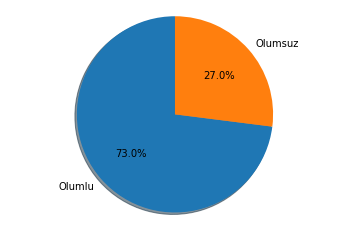

In [20]:
labels = twst.tweets.label.map({1:'Olumlu',0:'Olumsuz'}).value_counts().index.values
sizes = twst.tweets.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [21]:
data = twst.tweets.copy()


In [22]:
def preProcess(ReviewText):
    #Verideki <br> taglarını kaldır.
    ReviewText = ReviewText.str.lower()
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ') 
    #Verideki Linkleri Kaldır.
    ReviewText = ReviewText.str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]', ' ') 
    
    return ReviewText

data['Text'] = preProcess(data['Text'])

In [23]:
# Kök Bulma
stemmer = TurkishStemmer()

stemmed_lists = []
for index in tqdm(data.index):
    mini_l = []
    for text in data.loc[index]['Text'].split(" "):
        mini_l.append(stemmer.stem(text))

    big_text=" "
    for char in mini_l:
        big_text = big_text + " " + char
    stemmed_lists.append(big_text)
    
data['stemmed'] = stemmed_lists

100%|██████████| 100/100 [00:00<00:00, 1400.81it/s]


In [24]:
data.head()

,Tarih,Tweet_id,Text,label,score,stemmed
0,2022-06-16 16:23:56,1537471046441369600,rt çel son hafta içinde hem türkiye hem ...,1,0.995065,rt çel son haf iç hem türki hem de dün...
1,2022-06-16 16:23:53,1537471030578528257,disney aradım ip leri verdi...,1,0.832584,disney ara ip ler vert or...
2,2022-06-16 16:23:42,1537470984302649345,rt disney ın ilk yerli dizisi çış ın ilk ...,1,0.965883,rt disney ın ilk yerl dizi çış ın ilk b...
3,2022-06-16 16:23:35,1537470954623885316,disney ve netflix tr kendi arasında mentleşip...,0,0.907385,disney ve netflix tr kent ara mentleşip eğl...
4,2022-06-16 16:23:32,1537470944033259520,rt tutkulu bir aşk hikayesi olan west side ...,1,0.995168,rt tutku bir aşk hikaye olan west si stor...


In [25]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

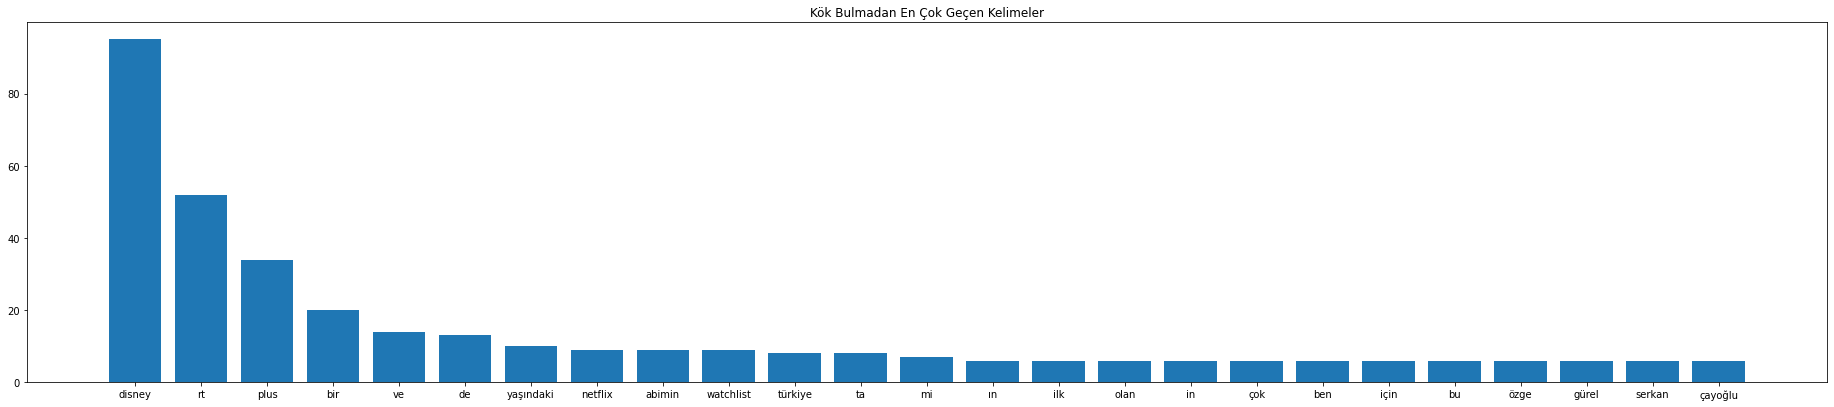

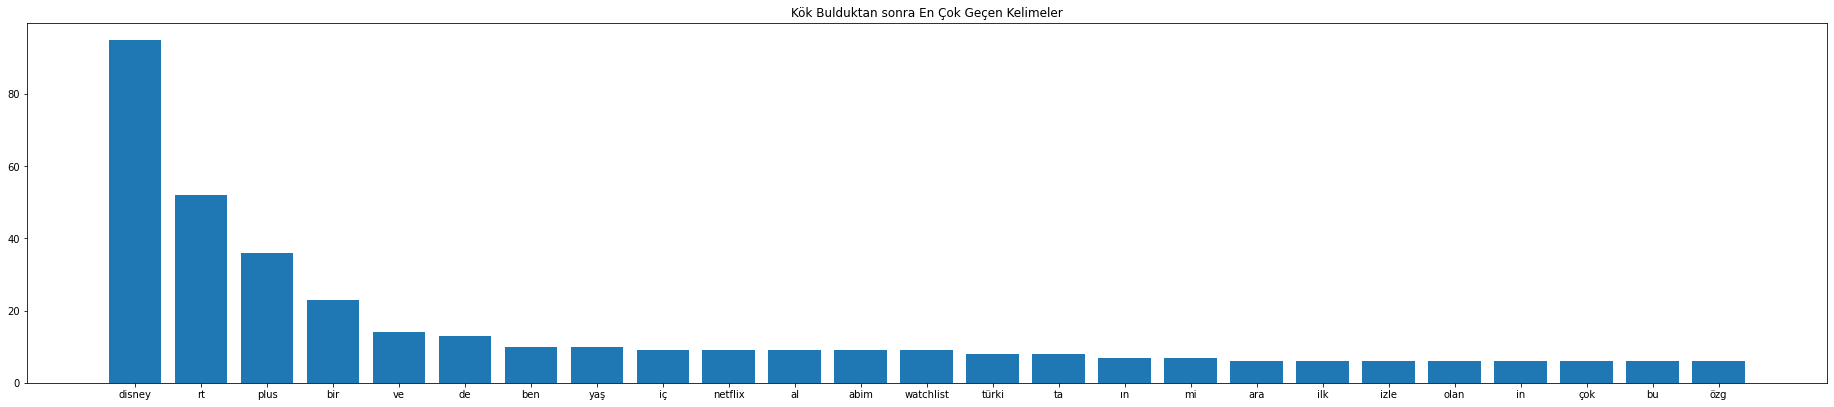

In [26]:
common_words = get_top_n_words(data['Text'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulmadan En Çok Geçen Kelimeler')
plt.show()


common_words = get_top_n_words(data['stemmed'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulduktan sonra En Çok Geçen Kelimeler')
plt.show()

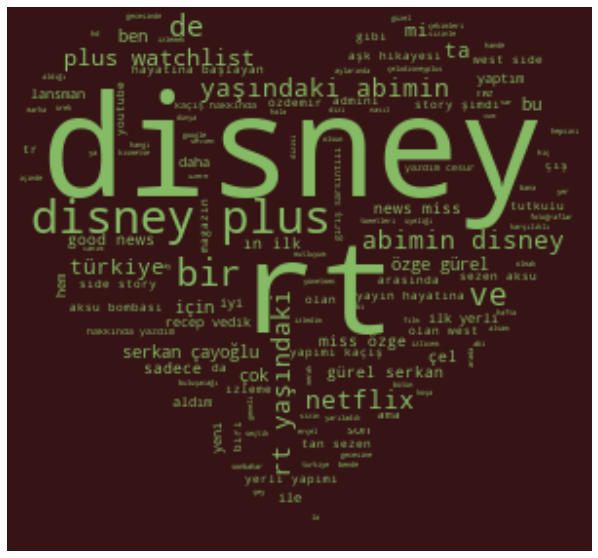

In [27]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.Text)

wine_mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/3/d/9/1/11949847661568287344heart_jon_phillips_01.svg.med.png', stream=True).raw))
wc = WordCloud(background_color="rgba(54,19,21,255)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("faruk.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

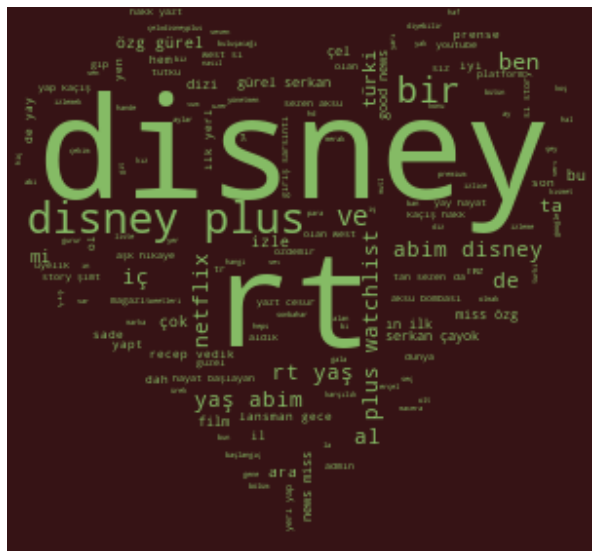

In [29]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.stemmed)

wine_mask = np.array(Image.open(requests.get("http://www.clker.com/cliparts/3/d/9/1/11949847661568287344heart_jon_phillips_01.svg.med.png", stream=True).raw))
wc = WordCloud(background_color="rgba(54,19,21,255)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()